#  Web Scraping and API

# EXERCISE 1: Scraping Data from a Website


In the lecture, we demonstrated how to extract data from a given website. In this tutorial, we will learn how to do so with Python.

We will use the following Python libraries:
- **Request**         for interacting with websites and web services
- **Beautiful Soup**  for webpage parsing

## Example 1: Web Scraping 'by hand'

In [68]:
from bs4 import BeautifulSoup
import requests


html = """
<html> 
<head>  <title>Python Programming</title> </head>
  <body>    
    <div id ="divCode">
              <h1><span class="uoscode">PP36122</span> - Python Programming</h1>
    </div>
    <div class="lecturer">Ali Anaissi</div>
    <div class="lecturer">Tony Huang</div>
    <div class="lecturer">Masoud Pouya</div>
    <p id="4711" class="description">PP36122 is about</p>
    <div id="results">
        <table class="data">
            <tr>
                <th>Weekly submissions</th>
                <th>Programming Quiz 1</th>
                <th>Programming Quiz 2</th>
                <th>Assignment</th>
            </tr>
            <tr>
                <td>10</td>
                <td>12</td>
                <td>16</td>
                <td>45</td>
            </tr>
        </table>
    </div>
  </body> 
</html> 

"""
page_content = BeautifulSoup(html, 'lxml')

#page_content = BeautifulSoup(html, 'html5lib') 
print(page_content.title)
lecturers = page_content('div', 'lecturer')
print("Lecturers")
for l in lecturers:
    print("\t-",l.text)



print(page_content.find('div', id='divCode').h1.text)
data_table = page_content.find("table")

headers = []
for h in data_table.find_all("th"):
    headers.append(h.string.replace(" ", "_"))
 

data_rows = data_table.find_all("tr")
results = {}
column = 0
total_marks = 0
for v in data_rows[1].find_all("td"):
    results[ headers[column] ] = float(v.string)
    column += 1
    total_marks += float(v.string)
print(25*"-") 
for k in results:
    print("%-15s : %5d" % (k, results[k]))
print(25*"-")
print("%-15s : %5d" % ("Final result",total_marks))





<title>Python Programming</title>
Lecturers
	- Ali Anaissi
	- Tony Huang
	- Masoud Pouya
PP36122 - Python Programming
-------------------------
Weekly_submissions :    10
Programming_Quiz_1 :    12
Programming_Quiz_2 :    16
Assignment      :    45
-------------------------
Final result    :    83


# COVID-19 data from the NSW Health website

## Example 2: Scrape the latest COVID-19 data from the NSW Health website

In [4]:
from bs4 import BeautifulSoup
import requests
html = requests.get("https://www.health.nsw.gov.au/news/Pages/20220329_00.aspx").text
page = BeautifulSoup(html, 'lxml')

page.title

<title>
	
	COVID-19 (Coronavirus) statistics - News

</title>

We can now identify parts of the page content directly, if we know their exact position in the HTML tree. Such as the printing of the page.title above.

Or we search for it across the page, ideally with ID, or tag name and its class to be as specific as possible:

In [5]:
page.select("div.newsdate")[0]

<div class="newsdate">
                29 March 2022        
            </div>

### Example 2.1: How many new COVID-19 cases yesterday?
Now let's look for the data with the case numbers. This is in a table...

In [6]:
tables = page.find_all('table')


In [7]:
print(len(tables))

3


In [8]:
tables[0].text

'LHDPositive PCR testsPositive RATsTotal casesWestern Sydney 1,211 1,791 3,002 Northern Sydney 931 1,962 2,893 Hunter New England 508 2,146 2,654 South Western Sydney 779 1,582 2,361 South Eastern Sydney 811 1,495 2,306 Sydney 692 1,082 1,774 Nepean Blue Mountains 408 918 1,326 Illawarra Shoalhaven 384 760 1,144 Central Coast 216 845 1,061 Western NSW 121 654 775 Murrumbidgee 52 531 583 Northern NSW 60 428 488 Mid North Coast 39 426 465 Southern NSW 80 383 463 Far West 10 57 67 Correctional settings 20 0 20 Under investigation83 29 112 Total6,405 15,089 21,494 '

In [9]:
table = tables[0]   
#would also work:
#table = page.select("table")[0]

columns = []
for th in table.select("th"):
    columns.append(th.text)
columns

['LHD', 'Positive PCR tests', 'Positive RATs', 'Total cases']

In [10]:
data = []
for tr in table.select("tr"):
    row = []
    for td in tr.select("td"):
        row.append(td.text)
    if len(row):
        data.append(row)
        
# first and last row and length of table
data[0], data[-1], len(data)

(['Western Sydney ', '1,211 ', '1,791 ', '3,002 '],
 ['Total', '6,405 ', '15,089 ', '21,494 '],
 18)

In [11]:
import pandas as pd
df = pd.DataFrame(data, columns=columns)
df.head(6)

,LHD,Positive PCR tests,Positive RATs,Total cases
0,Western Sydney,"1,211","1,791","3,002"
1,Northern Sydney,931,"1,962","2,893"
2,Hunter New England,508,"2,146","2,654"
3,South Western Sydney,779,"1,582","2,361"
4,South Eastern Sydney,811,"1,495","2,306"
5,Sydney,692,"1,082","1,774"


In [10]:
# much faster:
df2 = pd.read_html(str(tables[0]))[0]
df2

,LHD,Positive PCR tests,Positive RATs,Total cases
0,Western Sydney,1211,1791,3002
1,Northern Sydney,931,1962,2893
2,Hunter New England,508,2146,2654
3,South Western Sydney,779,1582,2361
4,South Eastern Sydney,811,1495,2306
5,Sydney,692,1082,1774
6,Nepean Blue Mountains,408,918,1326
7,Illawarra Shoalhaven,384,760,1144
8,Central Coast,216,845,1061
9,Western NSW,121,654,775


### Example 2.2: How many patients are currently in hospital in NSW with COVID?

This question is a bit more tricky because as our inspection of the page source finds, this information is part of the news release text, which is one of the variopus text paragraphs on the page without further logical marker...

It seems however to be a standard formulation, which starts with: "There are currently _X_ cases admitted to hospital..."

In [11]:
page.find(string="cases admitted to hospital")

This does not work as it is part of a string; so we need to use some pattern matching...

In [12]:
import re
hospital_status = page.find(string=re.compile("^There are currently"))
hospital_status

'There are currently 1,283 COVID-19 cases admitted to hospital, including 53 people in intensive care, 18 of whom require ventilation.'

In [13]:
re.findall(' [0-9]+,?[0-9]*', hospital_status)

[' 1,283', ' 53', ' 18']

### Example 2.3: Web Scraping using Pandas
For well-formatted data such as HTML tables or lists, Pandas does a pretty good job of extracting data from HTML into a dataframe.

In [14]:
covidlive_page_tables = pd.read_html("https://covidlive.com.au/report/daily-hospitalised/nsw",\
                                     attrs = {'class': 'DAILY-HOSPITALISED'}, \
                                     parse_dates = True, \
                                     converters={'DATE':str,'HOSP':int,'ICU':int,'VENT':int})

print(f'Total tables: {len(covidlive_page_tables)}')

Total tables: 1


In [15]:
# meaning of the columns on the example of the NSW Health press release form 1 Nov 2021:
# "There are currently 349 COVID-19 cases admitted to hospital, with 77 people in intensive care, 33 of whom require ventilation."
nsw_hospitalisations = covidlive_page_tables[0]
nsw_hospitalisations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    1031 non-null   object
 1   HOSP    959 non-null    object
 2   ICU     972 non-null    object
 3   VENT    955 non-null    object
dtypes: object(4)
memory usage: 32.3+ KB


### Example 2.4 Data Cleaning Examples

In [16]:
# more readable meta-data (column names)
nsw_hospitalisations.rename(columns={'DATE': 'date', 'HOSP': 'hospitalised', 'ICU': 'ICU', 'VENT': 'ICU_ventilated'}, inplace=True)
nsw_hospitalisations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            1031 non-null   object
 1   hospitalised    959 non-null    object
 2   ICU             972 non-null    object
 3   ICU_ventilated  955 non-null    object
dtypes: object(4)
memory usage: 32.3+ KB


In [17]:
# check the last five entries
nsw_hospitalisations.sort_values(by=['date'], inplace=True)
nsw_hospitalisations.tail()

,date,hospitalised,ICU,ICU_ventilated
903,31 May 20,11,1,0
538,31 May 21,3,1,0
173,31 May 22,1185,36,8
750,31 Oct 20,6,1,1
385,31 Oct 21,340,78,32


In [28]:
# convert date column to proper datetime type
#nsw_hospitalisations.date = pd.to_datetime(nsw_hospitalisations.date, format="DD/MM/YYYY")
nsw_hospitalisations.date = pd.to_datetime(nsw_hospitalisations.date)

In [29]:
# check the last five entries
nsw_hospitalisations.sort_values(by=['date'], inplace=True)
nsw_hospitalisations.tail()

,date,hospitalised,ICU,ICU_ventilated
4,2023-12-29,811,0,0
3,2024-01-05,811,0,0
2,2024-01-12,1152,0,0
1,2024-01-19,1152,0,0
0,2024-01-26,1152,0,0


In [30]:
# potential NaN / NULL handling
nsw_hospitalisations['ICU_ventilated'].fillna(0, inplace=True)
nsw_hospitalisations.tail()

,date,hospitalised,ICU,ICU_ventilated
4,2023-12-29,811,0,0
3,2024-01-05,811,0,0
2,2024-01-12,1152,0,0
1,2024-01-19,1152,0,0
0,2024-01-26,1152,0,0


### Example 2.5 Data Visualisation Examples

<Axes: >

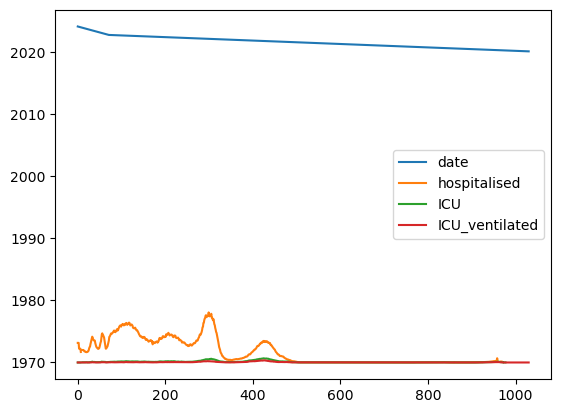

In [31]:
nsw_hospitalisations.plot()

Not quite yet what we want; let's concentrate on just omne specific curve - the number of hospitalised patients with COVID-19.

<Axes: >

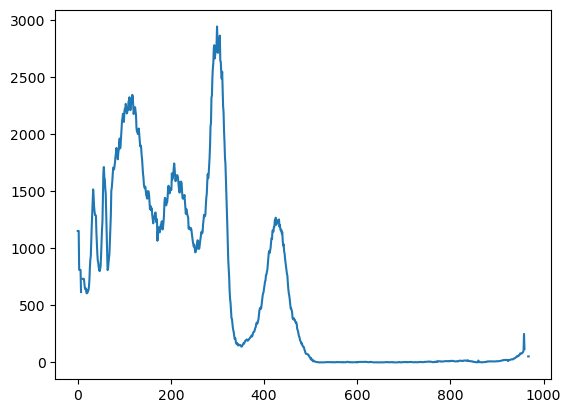

In [32]:
nsw_hospitalisations['hospitalised'].plot()

Better - now let's try to get the date column as index for the x-axes:

<Axes: >

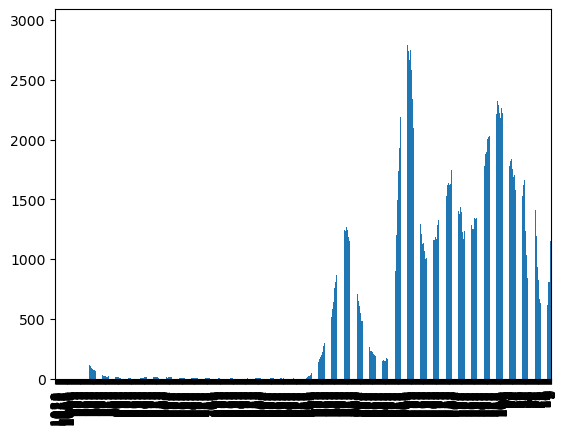

In [33]:
nsw_hospitalisations['hospitalised'].plot.bar(x='date')

Hard to read, let's zoom in a bit to the last 30 days:

<Axes: >

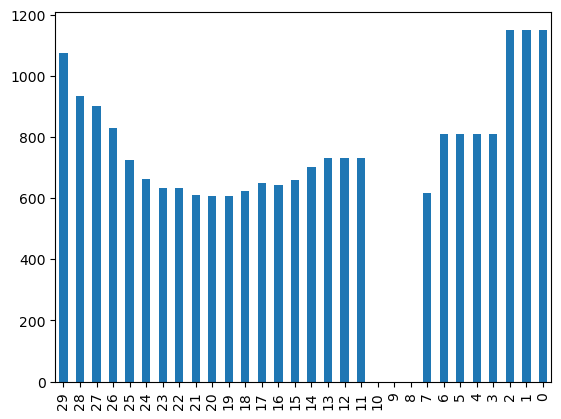

In [34]:
nsw_hospitalisations['hospitalised'].tail(30).plot.bar(x='date')

Let's make an attempt to plot the other two curves too, using a stacked bar chart:

<Axes: xlabel='date'>

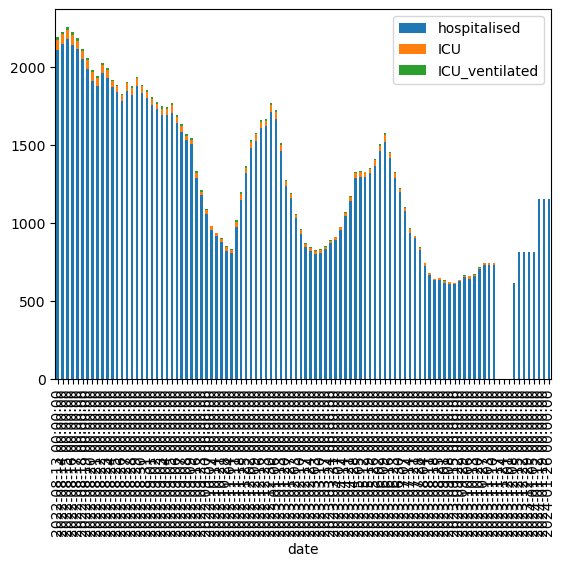

In [35]:
nsw_hospitalisations.tail(100).plot.bar(x='date', stacked=True)

The above plot has some disadvantages:
Besides that we cannot read the dates on the x-axis, it most importantly is *wrong*. We plotted the three patient numbers summative on top of each over so that their values are added up. But that's not the meaning of the data, the patients iof ICU are actually included in the number of the overall patients in hospital.

So let's correct this. The following final example demonstrates on how to plot a correct stacked bar chart with the given data, and also how to enhance the readability of the plot and include all neccesary axis and chart titles.
We are using the Seaaborn library here as an enhancement of matplotlib, and we define it within a utility function so that we can refer to it easily in different uses without having to repeat all these presentation tuning settings.

In [36]:
import matplotlib.pyplot as plt  # for graphics
import seaborn as sns            # for nicer graphics
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

def plot_hospitalisation_timeline(casestats, ndays):
    # we only want to plot the last 'ndays'
    casedata = casestats.tail(ndays)
    
    # correct the absolute numbers for the purpose of a stacked bar chart; hospitalised includes ICU, which includes ventilated; for plot need to 
    pd.options.mode.chained_assignment = None  # default='warn'
    casedata["hospital_only"] = casedata["hospitalised"] - casedata["ICU"]
    casedata["ICU_unventilated"]  = casedata["hospitalised"] - casedata["ICU_ventilated"]
    # prepare x-axis categoies; sns can't plot barchart+line together if x-axis is datetime???
    casedata['date'] = casedata['date'].apply(lambda d: d.strftime('%d.%m.')) 

    # plot the timeline of hospitalisations as a stacked bar chart
    sns.set_theme('notebook', 'ticks', font_scale=1.25)
    fig, ax1 = plt.subplots(figsize=(20,6))
    bar1 = sns.barplot (data=casedata, x='date', y='hospitalised',     color="#eb706d", ax=ax1)
    bar2 = sns.barplot (data=casedata, x='date', y='ICU_unventilated', color="#fcad43", ax=ax1)
    bar3 = sns.barplot (data=casedata, x='date', y='hospital_only',    color="#6589b2", ax=ax1)
    sns.despine()

    # format the plot axis and legend
    ax1.set_title("Daily COVID Hospital Patients in NSW")
    ax1.set_xlabel(None)
    ax1.set_ylabel("number of patients")
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(7))
    fig.autofmt_xdate()
    red_patch   = mpatches.Patch(color='#eb706d', label='ICU+ventilated')
    orange_patch= mpatches.Patch(color='#fcad43', label='ICU')
    blue_patch  = mpatches.Patch(color='#6589b2', label='hospitalised non ICU')
    legnd = ax1.legend(handles=[red_patch,orange_patch,blue_patch], loc='upper left', ncol = 1, prop={'size':14})

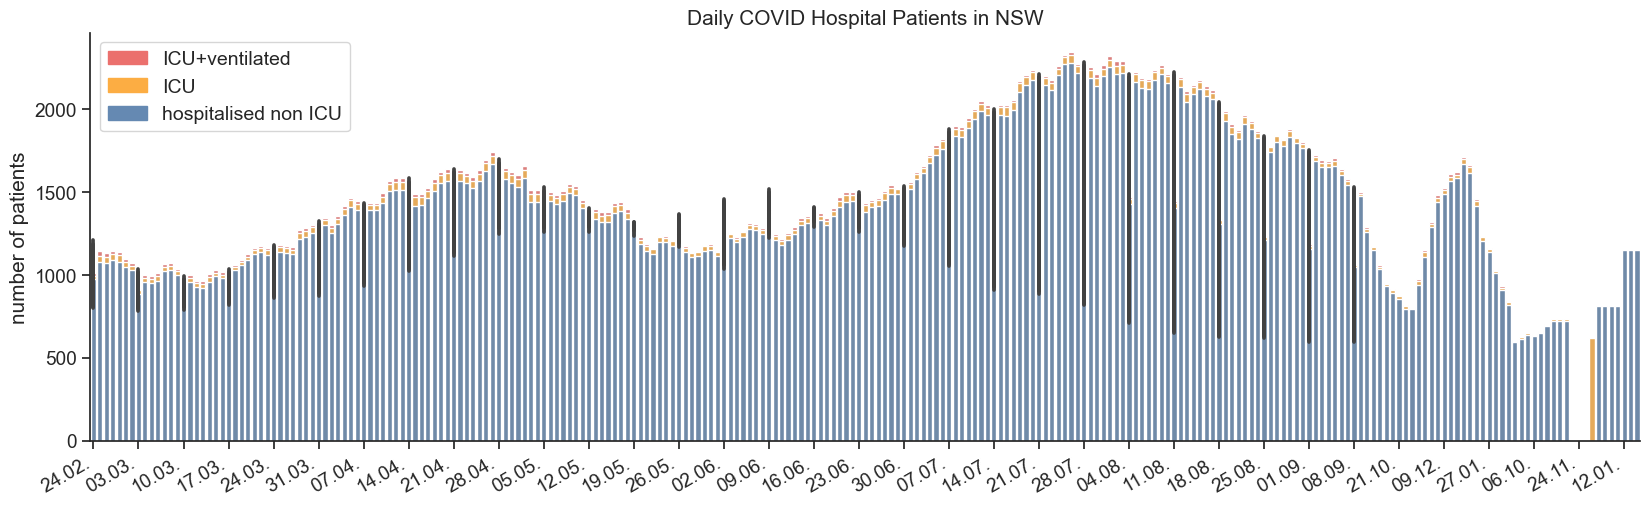

In [37]:
# Let's plot the last 4 to 9 months of hospitalisations
ndays = 270
plot_hospitalisation_timeline(nsw_hospitalisations, ndays)

# Question 1 - Scraping Data from The Reserve Bank of Australia

Our goal is to load data from the following website that makes available historic data about the Cash Rate Target, Lenders' Interest Rates,  Retail Payments, ..etc in  Australia:
https://www.rba.gov.au/

Let's start by having a look at the actual webpage. The following code requests the webpage for the cash rates from the Reserve Bank website (the given URL scheme is specific for this website):


In [1]:
import requests
webpage_source = requests.get("https://www.rba.gov.au/statistics/cash-rate/").text



In [2]:
from bs4 import BeautifulSoup
page_content = BeautifulSoup(webpage_source, 'lxml')

# Example 1: print the title element of the page content
print("Example 1: get a specific HTML element - such as the page title")
print(page_content.title)

# Example 2: print just the text of the title element using the 'text' operator
print("\nExample 2: get HTML element's text content")
print(page_content.title.string)

# Example 3: navigate along a tag sequence path and print content
print("\nExample 3: navigate along an element path to some content inside the page")
print(page_content.body.div['id'])

# Example 4: find ALL hyperlinks on the page (anywhere on the page, just print URL)
print("\nExample 4: find_all() URLs of hyperlinks on this webpage")
for link in page_content.find_all("a"):
    if (link.has_attr('href')):  
        print(link.get('href'));

Example 1: get a specific HTML element - such as the page title
<title>Cash Rate Target | RBA</title>

Example 2: get HTML element's text content
Cash Rate Target | RBA

Example 3: navigate along an element path to some content inside the page
page-cash-rate

Example 4: find_all() URLs of hyperlinks on this webpage
#content
https://www.rba.gov.au/
/monetary-policy/
/mkt-operations/
/payments-and-infrastructure/
/fin-stability/
/banknotes/
/fin-services/
/about-rba/
/media-releases/
/speeches/
/publications/
/statistics/
/chart-pack/
/research/
/about-rba/archives/
/education/
/careers/
/qa/
/contact/
/statistics/frequency/
/statistics/frequency/fin-agg/
/statistics/frequency/fin-agg/2023/
/statistics/frequency/fin-agg/2022/
/statistics/frequency/fin-agg/2021/
#nav-finagg-2011-2020
/statistics/frequency/fin-agg/2020/
/statistics/frequency/fin-agg/2019/
/statistics/frequency/fin-agg/2018/
/statistics/frequency/fin-agg/2017/
/statistics/frequency/fin-agg/2016/
/statistics/frequency/fin-ag

## Question 1.1: Interest Rate Decisions

Now that we have gained insights into webpage navigation, let's dive into the practical application. In this exercise, our goal is to extract information regarding the Interest Rate Decisions about the cash rate target. Subsequently, we aim to select an appropriate visualization method to effectively represent and comprehend this extracted data. Let's embark on this task to enhance our skills in web data extraction and visualization.


In [ ]:
#TODO replace the content of this cell with your Python solution.
raise NotImplementedError

## Question 1.2: Retail Payments

As part of the analysis, your task is to apply a standardized procedure to extract HTML data from two specified webpages. Specifically, focus on extracting information from the tables related to the Value of Retail Payments and the number of retail payments on both webpages. Pay particular attention to the data corresponding to the month of January for the years 2023 and 2022. Once the data extraction is complete, your next step is to generate comparison plots that vividly illustrate the trends in both the Value of Retail Payments and the number of retail payments over the specified timeframe. These plots will serve as valuable visualizations for understanding and comparing the patterns and fluctuations between the two years.



In [12]:
from bs4 import BeautifulSoup
import requests
html = requests.get("https://www.rba.gov.au/statistics/frequency/retail-payments/2022/retail-payments-0122.html").text
page = BeautifulSoup(html, 'lxml')

page.title

<title>Retail Payments January 2022 | RBA</title>

In [ ]:
#TODO replace the content of this cell with your Python solution.
raise NotImplementedError

In [159]:
from bs4 import BeautifulSoup
import requests
html = requests.get("https://www.rba.gov.au/statistics/frequency/retail-payments/2023/retail-payments-0123.html").text
page = BeautifulSoup(html, 'lxml')

page.title


<title>Retail Payments January 2023 | RBA</title>

In [ ]:
#TODO replace the content of this cell with your Python solution.
raise NotImplementedError

# STOP PLEASE. THE FOLLOWING IS FOR THE NEXT EXERCISE. THANKS.


 


# EXERCISE 2: Using Web APIs with JSON and XML to gather data

### Example 1: GitHub API
Extracting some information from the meta-data of a GitHub repository.

This is also an example of how to use the Pandas library to work with JSON data.

In [64]:
import requests
import pandas as pd

endpoint = "https://api.github.com/users/postgres/repos"
response = requests.get(endpoint)
repos    = json.loads(response.text)

print("Most recent 3 repositories:")
last_3_repositories = sorted (repos, key=lambda r: r["created_at"], reverse=True)[:3]

for repo in last_3_repositories:
    print(repo["name"], ":", repo["language"])

Most recent 3 repositories:
pgweb-static : HTML
pgarchives : Python
pgweb : HTML


In [65]:
# the same using Pandas
import requests
import pandas as pd
endpoint = "https://api.github.com/users/postgres/repos"
response = requests.get(endpoint)

df = pd.read_json(response.text)
df.sort_values(by='created_at', ascending=False, inplace=True)
df[['name','language','created_at']].head(3)


,name,language,created_at
2,pgweb-static,HTML,2019-11-05 19:47:15+00:00
0,pgarchives,Python,2019-11-01 11:08:32+00:00
1,pgweb,HTML,2011-12-18 15:28:47+00:00


In [66]:
# From the lecture slides: list of programming languages used in PostgreSQL for the last 5 updated repositories according to GitHub repositories
import requests
import pandas as pd

base_url = 'https://api.github.com/users/postgres/repos'
response = requests.get(base_url)

df = pd.read_json(response.text)

df.sort_values(by='updated_at', ascending=False, inplace=True)
df[['name','language','updated_at']].head(5)

,name,language,updated_at
3,postgres,C,2024-02-05 02:12:15+00:00
1,pgweb,HTML,2024-01-29 15:16:31+00:00
4,postgres-old-soon-decommissioned,C,2024-01-19 17:46:18+00:00
0,pgarchives,Python,2023-12-23 14:48:21+00:00
2,pgweb-static,HTML,2023-12-23 14:48:17+00:00


### Example 2: Web API returning XML

Some web APIs return data in **XML** format.
The easiest library to work with such kind of data in Python is called **lxml**.
Its documentation can be found here:<br>
http://lxml.de

In [67]:
###### In the "Justice News" RSS feed maintained by the Justice Department, the number of items published on a Friday
from datetime import datetime
from lxml import etree
import requests
url = 'https://www.justice.gov/feeds/opa/justice-news.xml'
news= requests.get(url).content
doc = etree.fromstring(requests.get(url).content)
items = doc.xpath('//channel/item')

# how many news items on last Friday?
dates = [item.find('pubDate').text.strip() for item in items]
ts = [datetime.strptime(d[0:16], "%a, %d %b %Y") for d in dates]
# for weekday(), 4 correspond to Friday
print(len([t for t in ts if t.weekday() == 4]))

# which news items were this
titles = [item.find('title').text for item in items]
titles

8


['Justice Department Announces New National Security Cyber Section Within the National Security Division',
 'Readout of Justice Department Convening with National Public Defense Organizations Hosted by the Office for Access to Justice',
 'Assistant Attorney General Matthew G. Olsen Delivers Remarks at Hoover Institution Announcing National Security Cyber Section',
 'Owner of Car Parts Remanufacturing Company  Pleads Guilty to Employment Tax Crime',
 'Federal Jury Convicts Three Defendants of Interstate Stalking of Chinese Nationals in the United States and Two Defendants of Acting or Conspiring to Act on Behalf of the People’s Republic of China',
 'Gerard R. Vetter Appointed Acting U.S. Trustee for Maryland, South Carolina, Virginia, West Virginia, and the District of Columbia',
 'Assistant Attorney General Jonathan Kanter Delivers Keynote Address at the Brookings Institution’s Center on Regulation and Markets Event “Promoting Competition in Banking” ',
 'Canadian Man Convicted in Mult

### Example 3: Map APIs
Here's another example with parameters send to a web service:

There are several MAP API systems that allow you to convert a location address to a GPS location (and some information more). The most popular of these is Google's Maps Platform. However, this underwent an access change in June 2018 which meant that it is now requires an API key and associated billing information.

So instead, we will be using the Open Street Maps project at https://www.openstreetmap.org. 
Note that this service does have however a restriction of 1 API call per second. 
The following example looks up the GPS location of UTS at "15 Broadway, Ultimo, Australia":


In [63]:
# Lookup of a given address via Open Street Maps Wep-API:
import requests
import time
import random
import pprint

def waitrequest(base_url, my_params):
    # wait 5 second before we make the request, ideally we can prevent too many requests this way 
    # if we do too many requests, the whole uni's IP range can be locked out!
    classsize = 25
    sleeptime = random.randint(1,classsize)
    print("waiting for "+str(sleeptime)+" seconds based on a class size of "+str(classsize))
    time.sleep(sleeptime)
    return requests.get(base_url, params = my_params)

base_url = 'https://nominatim.openstreetmap.org/search'
my_params= {'q': '15 Broadway, Ultimo, Australia','format':'json','polygon' : 1, 'addressdetails': 1 }

response = waitrequest(base_url, my_params)
results  = response.json()
if (results):
    # Check what the results look like
    print("This is what the response looks like:")
    pprint.pprint(results)
    if (len(results) > 0):
        x_geo    = results[0]
        print("Here is the Longitude and Latitude of our school:")
        print(x_geo['lon'], x_geo['lat'])
else:
    print("no results")

waiting for 20 seconds based on a class size of 25
This is what the response looks like:
[{'address': {'ISO3166-2-lvl4': 'AU-NSW',
              'building': 'UTS Tower',
              'city': 'Sydney',
              'country': 'Australia',
              'country_code': 'au',
              'house_number': '15',
              'municipality': 'Council of the City of Sydney',
              'postcode': '2007',
              'road': 'Broadway',
              'state': 'New South Wales',
              'suburb': 'Ultimo'},
  'addresstype': 'building',
  'boundingbox': ['-33.8840957', '-33.8831512', '151.2003357', '151.2013478'],
  'class': 'building',
  'display_name': 'UTS Tower, 15, Broadway, Ultimo, Sydney, Council of the '
                  'City of Sydney, New South Wales, 2007, Australia',
  'importance': 0.282582546755277,
  'lat': '-33.8836679',
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. '
             'http://osm.org/copyright',
  'lon': '151.20085784477652',
  'name': 

## Question 2: Retrieve Geo-Location of Arrival Ports of Convict Ship 'Adelaide' 
 - Where lies 'Van Diemen's Land'?<br>
   Use the Open Street Maps Web-API to check for the *GPS location* of the landing locations of the first voyage of the convict transportation ship "Adelaide" (cf. Exercise 1b): **Port Phillip** and **Van Diemen's Land**
 - Also retrieve the 'boundingbox'.<br>
   For this you might need to inspect first how the JSON response is structured: Do hence first a pretty-print of the corresponding JSON response data.
 - Tip: if you want to see a map for a given GPS location, try: https://www.latlong.net/


In [ ]:
#TODO replace the content of this cell with your Python solution.
raise NotImplementedErro